# Random effects model

$y_{i,t} = \alpha_i + \beta_i x_{t-1,i} + \gamma_i w_{t-1} + \epsilon_{t,i}$

$\alpha_i = \alpha_0 + \eta_{\alpha_i}$

$\beta_i = \beta_0 + \eta_{\beta_i}$

$\gamma_i = \gamma_0 + \eta_{\gamma_i}$

$\alpha_0 \sim \mathcal{N}(0, \tau_\alpha)$

$\beta_0 \sim \mathcal{N}(0, \tau_\beta)$

$\gamma_0 \sim \mathcal{N}(0, \tau_\gamma)$

$\eta_{\alpha_i} \sim \mathcal{N}(0, \tau_{\eta_\alpha})$

$\eta_{\beta_i} \sim \mathcal{N}(0, \tau_{\eta_\beta})$

$\eta_{\gamma_i} \sim \mathcal{N}(0, \tau_{\eta_\gamma})$

$\tau_\alpha, \tau_\beta, \tau_\gamma, \tau_{\eta_\alpha}, \tau_{\eta_\beta}, \tau_{\eta_\gamma} \sim \Gamma(1,1)$

In [1]:
import pandas as pd
from seminartools.data import read_inflation

In [12]:
df_inflation = read_inflation().assign(
    non_centered_t = lambda x: x["yearmonth"].dt.year * 12 + x["yearmonth"].dt.month
).assign(
    t = lambda x: x["non_centered_t"] - x["non_centered_t"].min()
).drop(columns=["non_centered_t"])
for lag in range(1, 5):
    df_inflation[f"inflation_lag_{lag}"] = df_inflation.groupby("Country")["inflation"].shift(lag)
df_inflation = df_inflation.dropna()

In [13]:
import bambi as bmb
import arviz as az
import jax

# if gpu available
inference_method = "mcmc"
try:
    import jax
    if jax.device_count() > 0:
        inference_method = "nuts_blackjax"
        print("GPU time")
except ImportError:
    pass

model = bmb.Model("inflation ~ (inflation_lag_1 | Country) + (0 + inflation_lag_2 | Country) + (0 + inflation_lag_3 | Country) + (0 + inflation_lag_4 | Country)", df_inflation)
res = model.fit(draws = 10000, chains = 1, tune = 1000, inference_method = inference_method)
res

Compiling...


GPU time


Compilation time = 0:00:01.864993
Sampling...
Sampling time = 0:05:09.009354
Transforming variables...
Transformation time = 0:00:00.414280


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'inflation_sigma'}>,
        <Axes: title={'center': 'inflation_sigma'}>],
       [<Axes: title={'center': '1|Country_sigma'}>,
        <Axes: title={'center': '1|Country_sigma'}>],
       [<Axes: title={'center': 'inflation_lag_1|Country_sigma'}>,
        <Axes: title={'center': 'inflation_lag_1|Country_sigma'}>],
       [<Axes: title={'center': 'inflation_lag_2|Country_sigma'}>,
        <Axes: title={'center': 'inflation_lag_2|Country_sigma'}>],
       [<Axes: title={'center': 'inflation_lag_3|Country_sigma'}>,
        <Axes: title={'center': 'inflation_lag_3|Country_sigma'}>],
       [<Axes: title={'center': 'inflation_lag_4|Country_sigma'}>,
        <Axes: title={'center': 'inflation_lag_4|Country_sigma'}>],
       [<Axes: title={'center': '1|Country'}>,
        <Axes: title={'center': '1|Country'}>],
       [<Axes: title={'center': 'inflation_lag_1|Country

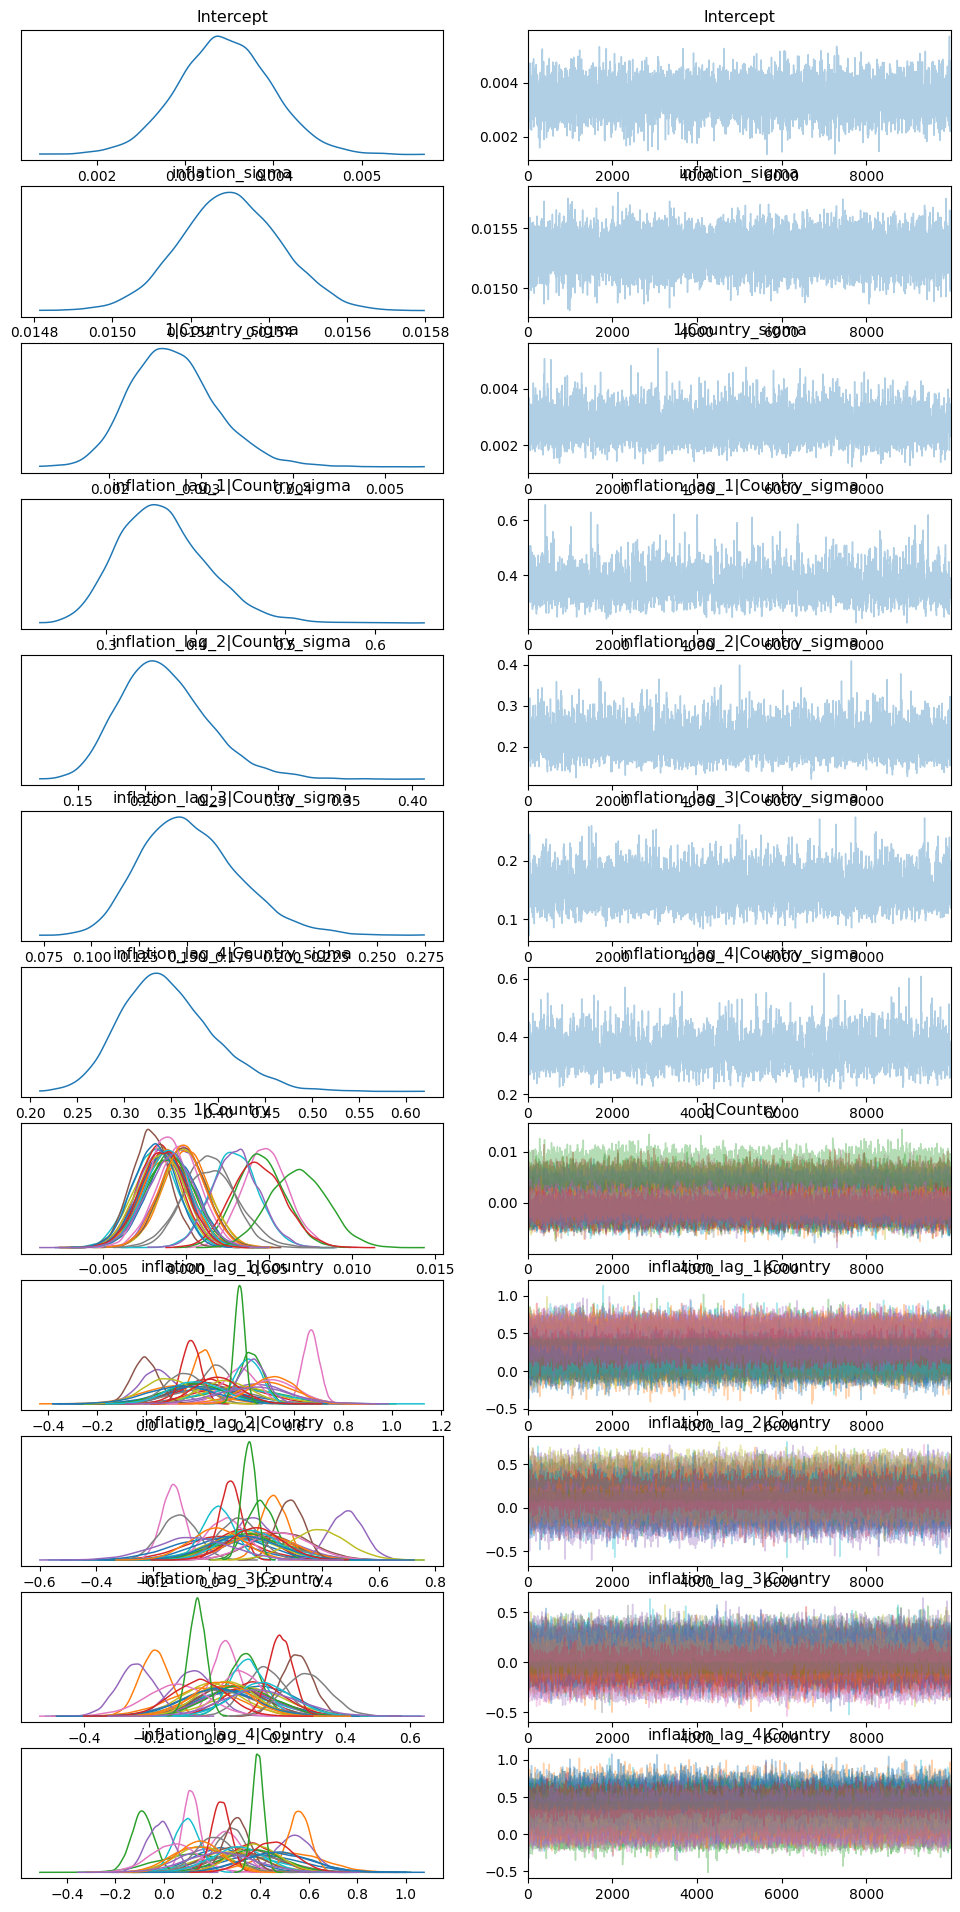

In [14]:
az.plot_trace(res)

In [15]:
az.summary(res).sort_values("mean")

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inflation_lag_3|Country[Philippines],-0.241,0.058,-0.347,-0.130,0.001,0.000,12145.0,8172.0,NaN
inflation_lag_3|Country[Greece],-0.185,0.046,-0.273,-0.103,0.000,0.000,11962.0,9161.0,NaN
inflation_lag_2|Country[Dominican Republic],-0.128,0.040,-0.201,-0.050,0.000,0.000,10006.0,7544.0,NaN
inflation_lag_3|Country[Singapore],-0.118,0.096,-0.305,0.060,0.001,0.001,10264.0,7673.0,NaN
inflation_lag_2|Country[Fiji],-0.108,0.066,-0.235,0.010,0.001,0.000,10146.0,7199.0,NaN
...,...,...,...,...,...,...,...,...,...
inflation_lag_1|Country[Thailand],0.516,0.090,0.348,0.688,0.001,0.001,12997.0,7258.0,NaN
inflation_lag_4|Country[Austria],0.518,0.143,0.243,0.782,0.002,0.001,9053.0,7835.0,NaN
inflation_lag_4|Country[Cyprus],0.541,0.075,0.393,0.676,0.001,0.000,13858.0,8751.0,NaN
inflation_lag_4|Country[Greece],0.560,0.045,0.478,0.648,0.000,0.000,14058.0,9027.0,NaN
